# 第5章: 係り受け解析

In [1]:
%system curl -O https://web.archive.org/web/20160731032405/http://www.cl.ecei.tohoku.ac.jp/nlp100/data/neko.txt

['  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current',
 '                                 Dload  Upload   Total   Spent    Left  Speed',
 '',
 '  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0',
 '  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0',
 '  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0',
 '  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0',
 '  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0',
 '  0     0    0     0    0     0      0      0 --:--:--  0:00:04 --:--:--     0',
 '  0     0    0     0    0     0      0      0 --:--:--  0:00:05 --:--:--     0',
 '100  943k  100  943k    0     0   149k      0  0:00:06  0:00:06 --:--:--  195k']

In [2]:
%system cabocha -f1 neko.txt > neko.txt.cabocha

[]

## 40. 係り受け解析結果の読み込み（形態素）

In [3]:
class Morph(object):
    def __init__(self, surface=None, base=None, pos=None, pos1=None):
        self.surface = surface
        self.base = base
        self.pos = pos
        self.pos1 = pos1

    def __str__(self):
        return '<surface: %s base: %s, pos: %s, pos1: %s>' % (self.surface, self.base, self.pos, self.pos1)

In [5]:
morphs = []
morphs_list = []
c = []

with open('neko.txt.cabocha') as fd:
    for line in map(lambda x: x.rstrip(), fd):
        features = line.split('\t')
        surface = features[0]

        if surface == '*':
            continue
        elif surface == 'EOS':
            if morphs:
                morphs_list.append(morphs)
            morphs = []

        elif len(features) > 1:
            morph_info = features[1].split(",")
            morph = Morph(surface, morph_info[6], morph_info[0], morph_info[1])

            morphs.append(morph)

print('\n'.join(map(str, morphs_list[2])))

<surface: 名前 base: 名前, pos: 名詞, pos1: 一般>
<surface: は base: は, pos: 助詞, pos1: 係助詞>
<surface: まだ base: まだ, pos: 副詞, pos1: 助詞類接続>
<surface: 無い base: 無い, pos: 形容詞, pos1: 自立>
<surface: 。 base: 。, pos: 記号, pos1: 句点>


## 41. 係り受け解析結果の読み込み（文節・係り受け）

In [6]:
class Chunk(object):

    def __init__(self, morphs=[], dst=None, srcs=[]):
        self.morphs = morphs
        self.dst = dst
        self.srcs = srcs

    def __str__(self):
        return '<text: %s, srcs: %s, dst: %s>' % (self.get_text(), self.srcs, self.dst)

    def get_text(self):
        return ''.join(m.surface for m in self.morphs if m.pos != '記号')

In [7]:
from collections import defaultdict


def parse():
    doc = []
    chunk_list = []
    srcs = defaultdict(list)

    with open('neko.txt.cabocha') as fd:
        for line in map(lambda x: x.rstrip(), fd):
            if line == 'EOS':
                for chunk_id, srcs_local in srcs.items():
                    if chunk_id != -1:
                        chunk_list[chunk_id].srcs = srcs_local

                doc.append(chunk_list)
                chunk_list = []
                srcs = defaultdict(list)

            elif line.startswith('* '):
                _, chunk_id, dst, *_ = line.split()
                chunk_id = int(chunk_id)
                dst = int(dst.replace('D', ''))

                chunk_list.append(Chunk(morphs=[], dst=dst, srcs=[]))
                srcs[dst].append(chunk_id)

            else:
                surface, features = line.split("\t")
                morph_info = features.split(",")
                morph = Morph(
                    surface,
                    morph_info[6],
                    morph_info[0],
                    morph_info[1]
                )
                chunk_list[-1].morphs.append(morph)
    return doc


doc = parse()
print('\n'.join(map(str, doc[7])))

<text: 吾輩は, srcs: [], dst: 5>
<text: ここで, srcs: [], dst: 2>
<text: 始めて, srcs: [1], dst: 3>
<text: 人間という, srcs: [2], dst: 4>
<text: ものを, srcs: [3], dst: 5>
<text: 見た, srcs: [0, 4], dst: -1>


## 42. 係り元と係り先の文節の表示

In [8]:
doc = parse()

for sentence in doc:
    for chunk in sentence:
        if chunk.dst and chunk.get_text() and chunk.dst != -1:
            print("%s\t%s" % (chunk.get_text(), sentence[chunk.dst].get_text()))

吾輩は	猫である
名前は	無い
まだ	無い
どこで	生れたか
生れたか	つかぬ
とんと	つかぬ
見当が	つかぬ
何でも	薄暗い
薄暗い	所で
じめじめした	所で
所で	ニャーニャー泣いて
ニャーニャー泣いて	記憶している
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
始めて	人間という
人間という	ものを
ものを	見た
しかも	種族であったそうだ
あとで	聞くと
聞くと	種族であったそうだ
それは	種族であったそうだ
書生という	人間中で
人間中で	種族であったそうだ
一番	獰悪な
獰悪な	種族であったそうだ
この	書生というのは
書生というのは	話である
時々	捕えて
我々を	捕えて
捕えて	煮て
煮て	食うという
食うという	話である
しかし	思わなかった
その	当時は
当時は	なかったから
何という	考も
考も	なかったから
なかったから	思わなかった
別段	恐し
恐し	思わなかった
いとも	思わなかった
ただ	載せられて
彼の	掌に
掌に	載せられて
載せられて	持ち上げられた
スーと	持ち上げられた
持ち上げられた	時
時	フワフワした
何だか	フワフワした
フワフワした	感じが
感じが	あったばかりである
掌の	上で
上で	落ちついて
少し	落ちついて
落ちついて	見たのが
書生の	顔を
顔を	見たのが
見たのが	人間という
いわゆる	人間という
人間という	ものの
ものの	見始であろう
この	時
時	ものだと
妙な	ものだと
ものだと	思った
思った	感じが
感じが	残っている
今でも	残っている
第一毛をもって	装飾されべきはずの
装飾されべきはずの	顔が
顔が	つるつるして
つるつるして	薬缶だ
まるで	薬缶だ
その後	逢ったが
猫にも	逢ったが
だいぶ	逢ったが
逢ったが	ない
こんな	片輪には
片輪には	ない
一度も	出会わした
出会わした	事が
事が	ない
のみならず	突起している
顔の	真中が
真中が	突起している
あまりに	突起している
そうして	吹く
その	穴の
穴の	中から
中から	吹く
時々	吹く
ぷうぷうと煙を	吹く
どうも	咽せぽくて
咽せぽくて	弱った
実に	弱った
これが	ものである
人間の	飲む
飲む	煙草という
煙草という	ものである
ものである	事は
事は	知った
ようやく	知った
この	頃
頃	知った
こ

## 43. 名詞を含む文節が動詞を含む文節に係るものを抽出

In [9]:
doc = parse()

for sentence in doc:
    for chunk in sentence:
        if chunk.dst != -1:

            if '名詞' in [m.pos for m in chunk.morphs] and '動詞' in [m.pos for m in sentence[chunk.dst].morphs]:
                print("%s\t%s" % (chunk.get_text(), sentence[chunk.dst].get_text()))

どこで	生れたか
見当が	つかぬ
所で	ニャーニャー泣いて
ニャーニャー泣いて	記憶している
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
ものを	見た
あとで	聞くと
我々を	捕えて
掌に	載せられて
スーと	持ち上げられた
時	フワフワした
感じが	あったばかりである
上で	落ちついて
顔を	見たのが
ものの	見始であろう
ものだと	思った
感じが	残っている
今でも	残っている
第一毛をもって	装飾されべきはずの
顔が	つるつるして
その後	逢ったが
猫にも	逢ったが
一度も	出会わした
真中が	突起している
中から	吹く
ぷうぷうと煙を	吹く
咽せぽくて	弱った
人間の	飲む
事は	知った
頃	知った
裏で	坐って
心持に	坐って
速力で	運転し始めた
書生が	動くのか
動くのか	動くのか
自分だけが	動くのか
動くのか	分らないが
眼が	廻る
胸が	悪くなる
音が	して
眼から	出た
火が	出た
それまでは	記憶しているが
記憶しているが	分らない
あとは	分らない
事やら	分らない
気が	付いて
書生は	いない
たくさん	おった
兄弟が	見えぬ
一疋も	見えぬ
母親さえ	隠してしまった
姿を	隠してしまった
所とは	違って
眼を	明いていられぬくらいだ
吾輩は	棄てられたのである
上から	棄てられたのである
急に	棄てられたのである
中へ	棄てられたのである
思いで	這い出すと
笹原を	這い出すと
向うに	ある
池が	ある
吾輩は	見た
前に	坐って
分別も	出ない
書生がまた	来てくれるかと
迎に	来てくれるかと
試みに	やって
誰も	来ない
上を	渡って
風が	渡って
日が	かかる
暮れ	かかる
腹が	減って来た
非常に	減って来た
声が	出ない
何でも	廻り始めた
食物の	ある
所まで	ある
決心を	して
池を	廻り始めた
左りに	廻り始めた
そこを	我慢して
我慢して	這って行くと
無理やりに	這って行くと
事で	出た
所へ	出た
ここへ	這入ったら
竹垣の	崩れた
穴から	もぐり込んだ
邸内に	もぐり込んだ
もので	餓死したかも知れんのである
竹垣が	破れていなかったなら
吾輩は	餓死したかも知れんのである
路傍に	餓死したかも知れんのである
蔭とは	云った
穴は	なっている
今日に	至るまで
吾輩が	訪問する
三毛を	訪問する
通

## 44. 係り受け木の可視化

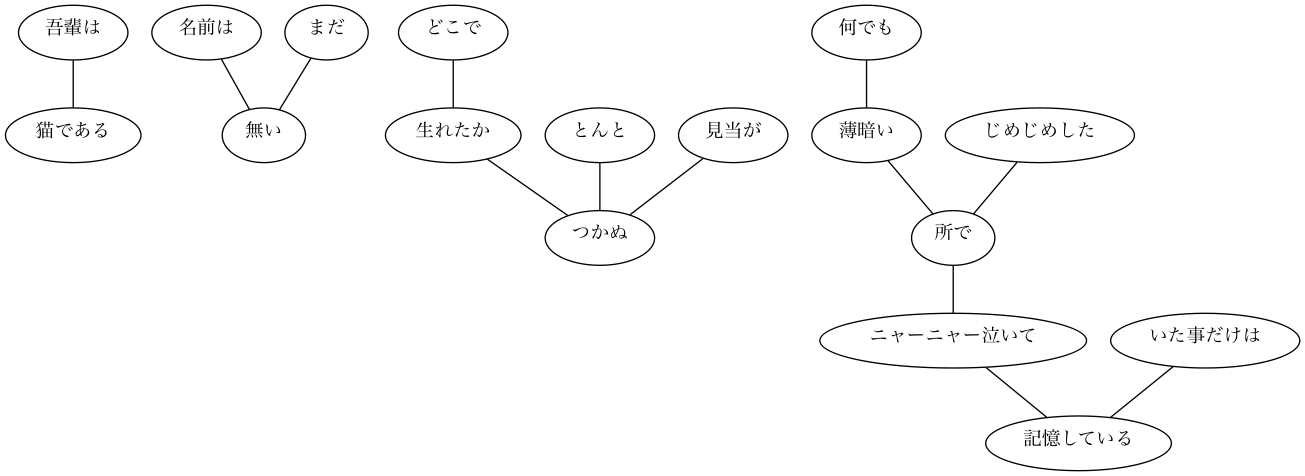

In [10]:
from IPython.display import Image, display
import pydot

doc = parse()


def show(doc):
    edges = []
    for sentence in doc:
        for chunk in sentence:
            if chunk.dst and chunk.get_text() and chunk.dst != -1:
                edges.append((chunk.get_text(), sentence[chunk.dst].get_text()))
    graph = pydot.graph_from_edges(edges)
    plt = Image(graph.create_png(prog='dot'))
    display(plt)


show(doc[:7])

## 45. 動詞の格パターンの抽出

In [11]:
for sentence in doc:
    for chunk in sentence:
        if '動詞' in [m.pos for m in chunk.morphs]:

            predicate = [m.base for m in chunk.morphs if m.pos == '動詞'][0]

            case_list = []
            for src in chunk.srcs:
                if '助詞' in [m.pos for m in sentence[src].morphs]:
                    case = [m.base for m in sentence[src].morphs if m.pos == '助詞'][-1]
                    case_list.append(case)

            if case_list:
                case_list.sort()
                print('%s\t%s' % (predicate, ' '.join(case_list)))

生れる	で
つく	か が
泣く	で
する	て は
始める	で
見る	は を
聞く	で
捕える	を
煮る	て
食う	て
思う	から
載せる	に
持ち上げる	て と
ある	が
落ちつく	で
見る	て を
見る	の
思う	と
残る	が でも
する	をもって
する	が
逢う	も
出会う	も
する	が
吹く	から を
弱る	て
飲む	の
知る	は
坐る	で に
おる	て
する	が で と
動く	が
動く	か が
分る	か
廻る	が が
なる	が
思う	と
する	が と
出る	から が て と
する	は
分る	が は も やら
付く	が
見る	て
いる	と は
見える	が も
隠す	さえ を
違う	は
明く	を
見る	て
棄てる	から に は へ
這い出す	で を
ある	が と に
坐る	に
する	て
考える	と
見る	て は
出る	も
泣く	て
来る	が に
考え付く	と
やる	に
見る	て
来る	が も
渡る	が と を
かかる	が て
減る	が に
出る	が も
ある	の
ある	まで
する	と を
そる	て
廻る	に も を
する	を
這う	て に
出る	で と へ
這入る	へ
思う	と
崩れる	の
もぐり込む	から て に
破れる	が
する	て に は
云う	は
至る	に
する	が まで を
なる	に は
忍び込む	は
分る	か ものの
なる	に
減る	は
降る	が
出来る	が で
あるく	と へ
考える	から
這入る	に
おる	て と は
見る	を
する	で に は
逢う	に
見る	で より を
つかむ	を
抛り出す	で は へ や
思う	と
ねぶる	を
任せる	から て に を
出来る	が は
見る	を
這う	て は へ
這う	は は
投げ出す	は
繰り返す	でも を
する	を
云う	と に
なる	は
する	を
やる	て んで
下りる	から が
つまみ出す	が に
いう	と
出る	が ながら に
ぶら下げる	を
向ける	へ
出す	が
出す	て て も
上る	へ
困る	て は も
いう	と
撚る	を
眺める	ながら を
おる	て は
置く	へ
這入る	が といった へ
聞く	を
見える	と は
抛り出す	に は へ を
極める	と を
する	に は
合せる	と に を
帰る	から
這入る	と に
思う	と
いう	が
覗く	に を
見る	て は
する	を
ある	が が 

## 46. 動詞の格フレーム情報の抽出

In [12]:
sentence = doc[7]

for chunk in sentence:
    if '動詞' in [m.pos for m in chunk.morphs]:

        predicate = [m.base for m in chunk.morphs if m.pos == '動詞'][0]
        arguments = []

        for src in chunk.srcs:
            if '助詞' in [m.pos for m in sentence[src].morphs]:
                argument = sentence[src].get_text()
                case = [m.base for m in sentence[src].morphs if m.pos == '助詞'][-1]
                arguments.append((case, argument))

        if arguments:
            arguments.sort()
            print("%s\t%s\t%s" % (predicate, ' '.join([a[0] for a in arguments]), ' '.join([a[1] for a in arguments])))

始める	で	ここで
見る	は を	吾輩は ものを


## 47. 機能動詞構文のマイニング

In [13]:
for sentence in doc:
    for chunk in sentence:
        if '動詞' in [m.pos for m in chunk.morphs]:

            sahens = [m.base for m in chunk.morphs if m.pos1 == 'サ変接続']
            if not sahens:
                continue
            verb = predicate = [m.base for m in chunk.morphs if m.pos == '動詞'][0]
            predicate = sahens[0] + 'を' + verb
            arguments = []

            for src in chunk.srcs:
                if '助詞' in [m.pos for m in sentence[src].morphs]:
                    argument = sentence[src].get_text()
                    case = [m.base for m in sentence[src].morphs if m.pos == '助詞'][-1]
                    arguments.append((case, argument))

            if arguments:
                arguments.sort()
                print("%s\t%s\t%s" % (predicate, ' '.join([a[0] for a in arguments]), ' '.join([a[1] for a in arguments])))

記憶をする	て は	ニャーニャー泣いて いた事だけは
装飾をする	をもって	第一毛をもって
突起をする	が	真中が
運転をする	が で と	おったが 速力で すると
記憶をする	は	それまでは
我慢をする	を	そこを
餓死をする	て に は	破れていなかったなら 路傍に 吾輩は
訪問をする	が まで を	吾輩が 至るまで 三毛を
遭遇をする	で に は	ここで 機会に 吾輩は
記憶をする	を	繰り返したのを
同居をする	と	人間と
観察をする	て を	同居して 彼等を
断言をする	と は は ほど	ものだと 吾輩は 彼等は ほど
同衾をする	が	吾輩が
尊敬をする	の	吾輩の
剿滅をする	て は を	戦って するには これを
憤慨をする	て に	いって 大に
掠奪をせる	に は	ために 御馳走は
失敗をする	から が で	思い出したから 主人が 我儘で
関をする	も	つけられているにも
感心をする	と は	その通りだと 主人は
失笑をする	て	見て
揶揄をせる	に	友に
写生をする	として に は を	結果として 手初めに 彼は 吾輩を
自白をする	は	吾輩は
写生をする	は を	これは ところを
判然をする	か から が	猫だか 写生したのだから ないが
感服をする	は	熱心には
増長をする	て は	慢じて ものは
増長をする	まで	先どこまで
我慢をする	くらい も	くらいなら 我儘も
佇立をする	て と に	忘れて 念と 前に
記憶をする	でも	今でも
珍重をする	の	人間の
軽蔑をせる	に	大に
察をする	から	言葉付から
肥満をする	て	切って
交際をする	から も	ないから 誰も
邂逅をする	と は	黒と 吾輩は
自慢を話す	の	いつもの
質問をする	て で と の の は	向って あとで していると 下のごとく 例のごとく 彼は
発達をする	は も	智識は 黒よりも
感心をする	て を	あって 気焔を
謹聴をする	て に	鳴らして 感心したように
弁護をする	を	己れを
吶喊をする	に は	欠所に 彼は
感心をする	と	ふんと
喝采をする	と	やったねと
呈出をする	は は も を	君は 質問は 不思議にも 結果を
大息をする	として	喟然として
決心をする	から と	時から とるまいと
自任をする	をもって	放蕩家をもって
卒業をする	で	もので
関

## 48. 名詞から根へのパスの抽出

In [14]:
sentence = doc[7]
for chunk in sentence:
    if '名詞' in [m.pos for m in chunk.morphs] and chunk.dst != -1:
        print('%s' % chunk.get_text(), end='')
        chunk_dst = chunk.dst
        while chunk_dst != -1:
            print(' -> %s' % (sentence[chunk_dst].get_text()), end='')
            chunk_dst = sentence[chunk_dst].dst
        print()

吾輩は -> 見た
ここで -> 始めて -> 人間という -> ものを -> 見た
人間という -> ものを -> 見た
ものを -> 見た


## 49. 名詞間の係り受けパスの抽出

In [15]:
from itertools import combinations


def noun_pairs(sentence):
    noun_chunks = []
    for chunk in sentence:
        if '名詞' in [m.pos for m in chunk.morphs]:
            noun_chunks.append(chunk)
    return list(combinations(noun_chunks, 2))


def replace_noun(chunk, alt):
    for (i, morph) in enumerate(chunk.morphs):
        if morph.pos == '名詞':
                chunk.morphs[i].surface = alt
    return chunk


def path_to_root(chunk, sentence):
    if chunk.dst == -1:
        return [chunk]
    else:
        return [chunk] + path_to_root(sentence[chunk.dst], sentence)


def join_chunks_by_arrow(chunks):
    return ' -> '.join([c.get_text() for c in chunks])


def common_chunk(path_i, path_j):
    _chunk_k = None
    path_i = list(reversed(path_i))
    path_j = list(reversed(path_j))
    for idx, (c_i, c_j) in enumerate(zip(path_i, path_j)):
        if c_i.srcs != c_j.srcs:
            _chunk_k = path_i[idx - 1]
            break
    return _chunk_k


for sentence in doc[7:8]:

    n_pairs = noun_pairs(sentence)
    if not n_pairs:
        continue

    for (chunk_i, chunk_j) in n_pairs:
        chunk_i = replace_noun(chunk_i, 'X')
        chunk_j = replace_noun(chunk_j, 'Y')

        path_chunk_i_to_root = path_to_root(chunk_i, sentence)
        path_chunk_j_to_root = path_to_root(chunk_j, sentence)

        if chunk_j in path_chunk_i_to_root:
            idx_j = path_chunk_i_to_root.index(chunk_j)
            print(join_chunks_by_arrow(path_chunk_i_to_root[0: idx_j + 1]))
        else:
            chunk_k = common_chunk(path_chunk_i_to_root, path_chunk_j_to_root)
            if chunk_k is None:
                continue
            idx_k_i = path_chunk_i_to_root.index(chunk_k)
            idx_k_j = path_chunk_j_to_root.index(chunk_k)

            print(' | '.join([join_chunks_by_arrow(path_chunk_i_to_root[0: idx_k_i]),
                              join_chunks_by_arrow(path_chunk_j_to_root[0: idx_k_j]),
                              chunk_k.get_text()]))

Xは | Yで -> 始めて -> 人間という -> ものを | 見た
Xは | Yという -> ものを | 見た
Xは | Yを | 見た
Xで -> 始めて -> Yという
Xで -> 始めて -> Yという -> Yを
Xという -> Yを
